In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys

path_to_this_notebook = os.path.abspath('.')
path_to_project = path_to_this_notebook[:path_to_this_notebook.find('note')]
sys.path.append(path_to_project)

import matplotlib.pyplot as plt
import numpy as np

from src.samplers.load_samplers import load_samplers
from src.environments.create_env import create_env
from src.optimization.heuristic_greedy import compute_greedy_heuristic
from src.optimization.determenistic_solution import compute_deterministic_solution

%matplotlib inline

In [3]:
def plot_results(env, results_list, figsize=(12, 7)):
    plt.figure(figsize=figsize)
    plt.subplot(121)
    i_violations = [res['i_constraints_violation'] for res in results_list]
    p_violations = [res['power_flow_constraints_violation'] for res in results_list]
    plt.plot(env.timesteps_str[:-1], i_violations, label='i_violation')
    plt.plot(env.timesteps_str[:-1], p_violations, label='p_violation')
    _ = plt.xticks(env.timesteps_str[::6])
    _ = plt.legend()
    _ = plt.title('Constraint violations')

    plt.subplot(122)
    rewards = [res['reward'] for res in results_list]
    feeders_price = [res['feeders_power_price'] for res in results_list]
    pvs_price = [res['pvs_power_price'] for res in results_list]
    evs_welfare = [res['evs_social_welfare'] for res in results_list]

    plt.plot(env.timesteps_str[:-1], rewards, label='total reward')
    plt.plot(env.timesteps_str[:-1], feeders_price, label='feeders price')
    plt.plot(env.timesteps_str[:-1], pvs_price, label='PVs price')
    plt.plot(env.timesteps_str[:-1], evs_welfare, label='EVs welfare')
    _ = plt.xticks(env.timesteps_str[::6])
    _ = plt.legend()
    _ = plt.title('Objective')

### Config and data loading

In [4]:
config = {'path_to_data': path_to_project + '/data/', 
          't0_hr': 6., # When the episode start (default value 6AM)
          'dt_min': 30, # Timestep size
          'ev_dt_min': 60, # Timestep size for EV arrivals
          'ev_sampling_dt_min': 60,  # How EV sessions are sampled from the data
          'apply_gaussian_noise': False, # Make data noisy
          'ev_utility_coef_mean': 1, # Mean value of the utility coefficient for the EVs
          'ev_utility_coef_scale': 0.13, # STD of the utility coefficient for the EVs
          'days_per_month_train': 20, # Days per month for training 
          'ev_session_months_train': ['01', '02', '03', '04', '06', '07', '08', '09', '10', '11',],
           # Months to sample EV sessions for training 
          'grid_to_use': 'ieee16', # What grid topology to use. Now supports only IEEE16. 
          'ev_session_months_test': ['05', '12'], # Months to sample EV sessions for test 
          'n_ps_pvs': 4, # Amount of solar panels that use PecanStreet data
          'n_canopy_pvs': 0, # Amount of solar panels that use canopy data
          'canopy_pv_rated_power': 250, # Rated power of these panels
          'n_loads': 0, # Amount of inflexible loads
          'n_feeders': 1, # Amount of feeders
          'n_ev_chargers': 4, # Amount of EV chargers
          
          'ps_pvs_rated_power': 4, # Rated power of these panels
          'avg_evs_per_day': 3.5, # Scaling of the EV arrival rate
          'feeder_p_min': -5, # Capacity of the feeders
          'g': 4, # Conductance of each line
          'i_max': 25, # Capacity of each line
          }

In [5]:
# Preload samplers, it is necessary to avoid re-loading data each time env is created
(ps_samplers_dict, ps_metadata, canopy_sampler, canopy_metadata,
 price_sampler, price_metadata, ev_sampler, elaadnl_metadata) = load_samplers(config)

In [29]:
# Create environment
env = create_env(config, ps_samplers_dict, ps_metadata, canopy_sampler, canopy_metadata,
                 price_sampler, price_metadata, ev_sampler, elaadnl_metadata)
print(env)
# env.plot_grid(bbox=(0, 0, 500, 500))

<GymPowerVoltageEnv instance>


### Sample runs using heuristics

In [22]:
# Greedy heuristic which solves single-timestep OPF
np.random.seed(42)
env.reset(episode_index=0, train=True)
results_list = []
total_reward = 0
steps = 0
state = env.reset()
mins = [np.inf, np.inf, np.inf, np.inf, np.inf]
maxs = [-np.inf, -np.inf, -np.inf, -np.inf, -np.inf]
while not env.done:
    reshaped = state.reshape(-1, env.n_devices)
    current_min = reshaped.min(axis=1)
    current_max = reshaped.max(axis=1)
    mins = np.concatenate((mins, current_min)).reshape(-1, 5)
    mins = mins.min(axis=0)
    maxs = np.concatenate((maxs, current_max)).reshape(-1, 5)
    maxs = maxs.max(axis=0)
    steps += 1
    # print('t=%s' % env.t_str)
    # p_lbs_t, p_ubs_t, v_lbs_t, v_ubs_t, u_t = env.compute_current_state()

    # p, v, model = compute_greedy_heuristic(u_t, p_lbs_t, p_ubs_t, v_lbs_t, v_ubs_t, 
    #                                        env.conductance_matrix, env.i_max_matrix, 
    #                                        lossless=False, tee=False)
    action_voltages = np.full(22, 300)
    action_powers = np.full(22, 0)
    action = np.concatenate((action_powers, action_voltages), axis=0)
    next_state, reward, done, info = env.step(action)
    total_reward += reward
    results_list.append(reward)
    state = next_state
print('Reward = %.2f' % total_reward)
print(mins)
print(maxs)
# plot_results(env, results_list, figsize=(12, 7))

Reward = 0.00
[ -5.   0. 300. 400.   0.]
[  0.          10.         300.         400.           1.28467438]


In [ ]:
# Greedy heuristic which solves single-timestep OPF using lossless model
# It gets higher reward, but violates the power-flow constraints. 
np.random.seed(42)
env.reset(episode_index=0, train=True)
results_list = []
total_reward = 0
while not env.done:
    # print('t=%s' % env.t_str)
    p_lbs_t, p_ubs_t, v_lbs_t, v_ubs_t, u_t = env.compute_current_state()
    p, v, model = compute_greedy_heuristic(u_t, p_lbs_t, p_ubs_t, v_lbs_t, v_ubs_t, 
                                           env.conductance_matrix, env.i_max_matrix, 
                                           lossless=True, tee=False)
    result = env.step(p, v)
    total_reward += result['reward']
    results_list.append(result)
print('Reward = %.2f' % total_reward)
plot_results(env, results_list, figsize=(12, 7))

    solver 'glpk'


ApplicationError: No executable found for solver 'glpk'

### Same simulation but using a deterministic planner

Reward = 356.62


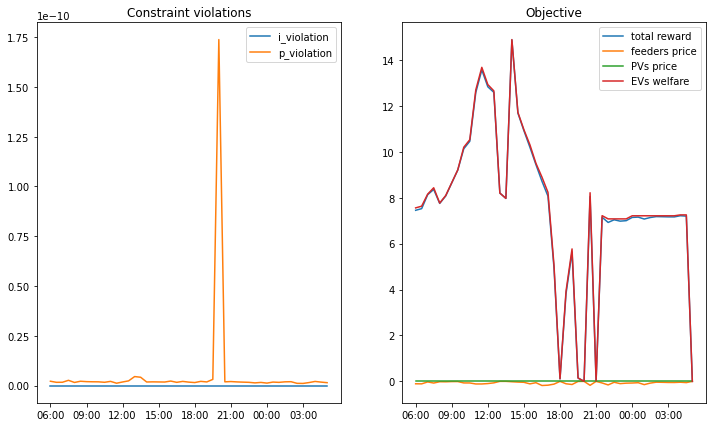

In [ ]:
# Deterministic solution solves the full planning problem using perfect knowledge of the future.
# As expected, it receives higher reward.
np.random.seed(42)
env.reset(episode_index=0, train=True)

p_lbs, p_ubs, v_lbs, v_ubs, u, evs_dict = env.compute_full_state(uncertainty='deterministic')
p_det, v_det, model = compute_deterministic_solution(env.dt_min, evs_dict, u[0], p_lbs[0], 
                                                     p_ubs[0], v_lbs[0], v_ubs[0], 
                                                     env.conductance_matrix, env.i_max_matrix,
                                                     lossless=False, tee=False)
results_list = []
total_reward = 0
while not env.done:
    result = env.step(p_det[env.t_ind], v_det[env.t_ind])
    total_reward += result['reward']
    results_list.append(result)
print('Reward = %.2f' % total_reward)
plot_results(env, results_list, figsize=(12, 7))

### The goal of the project is to come up with an RL based method that computes nodal powers and voltages that maximize the objective while keeping the constraint violations small.  The above simulations use the benchmarks that you should be comparing to. Clearly, you want to beat the greedy heuristic , but you can't beat the determenistic planner as it is the absolute optimal solution (assuming known future).